<a href="https://colab.research.google.com/github/omar-roa/deep-learning/blob/main/03%20-%20arquitectura%20de%20linea%20de%20base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Librerías

In [332]:
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [333]:
def matrix_conf(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)

    # Normalizar
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Graficar
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap="Blues", annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show(block=False)

    return ax

# 1. Retomamos el dataset preprocesado

Tendremos dos datasets para contrastar el desempeño de los modelos


1.   Dataset depurado sin balancear (1.187.782 registros) ds_v4
2.   Dataset depurado y balanceado (780.004 registros) ds_v5


In [334]:
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IQGn8-uMQlmriI0daCF0wJq4xUnkcekv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IQGn8-uMQlmriI0daCF0wJq4xUnkcekv" -O SDN_Intrusion4.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-0pXxJzz47VJAOLp6vDnRQc3OLETGcQL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-0pXxJzz47VJAOLp6vDnRQc3OLETGcQL" -O SDN_Intrusion5.csv && rm -rf /tmp/cookies.txt

In [335]:
ds_v4 = pd.read_csv('/content/SDN_Intrusion4.csv')
ds_v5 = pd.read_csv('/content/SDN_Intrusion5.csv')

In [336]:
ds_v4['Class'].value_counts()

1    797780
0    383430
2      4550
3      1962
4        60
Name: Class, dtype: int64

Tendremos dos escenario:


*   Caso de clasificación binaria: BENIGNO vs ATAQUE
*   Caso de clasificación multiclase: BENIGNO vs DDoS vs Brute Force vs XSS vs Sql Injection

In [337]:
# Separamos las entradas de la salida
X = ds_v4.drop(columns=({'Class'}))

# Salida para el caso multiclase
y_multi = ds_v4['Class']
dict_multi = {0: 'DDoS', 1: 'BENIGN', 2: 'Web Attack - Brute Force', 3: 'Web Attack - XSS', 4: 'Web Attack - Sql Injection'}

# Salida para el caso binario
y_bin = y_multi.replace([2, 3, 4], 0)
dict_bin = {0: 'ATTACK', 1: 'BENIGN', }

# Haremos un escalamiento Max-Min entre 0 y 1
scaler = MinMaxScaler()
X_sc = X
X_sc[X.columns] = scaler.fit_transform(X)

Verificamos que el escalamiento se haya sido realizado sin problema


In [338]:
X_sc.describe()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,...,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd
count,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,...,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06,1.187782e+06
mean,1.292702e-01,4.283834e-05,3.984613e-05,6.554129e-04,1.633813e-02,2.760880e-02,2.148232e-02,1.317206e-01,9.931579e-02,9.193903e-02,...,1.352971e-01,2.760880e-02,9.931579e-02,5.263823e-05,4.283834e-05,6.554129e-04,3.984613e-05,7.788111e-02,2.096018e-02,3.796426e-05
std,2.921122e-01,3.710986e-03,3.656775e-03,4.810782e-03,6.237066e-02,9.371265e-02,9.218685e-02,2.338310e-01,1.615738e-01,1.745046e-01,...,1.925221e-01,9.371265e-02,1.615738e-01,3.723173e-03,3.710986e-03,4.810782e-03,3.656775e-03,1.635623e-01,1.085894e-01,3.712643e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.087652e-04,4.981221e-06,3.694317e-06,2.171736e-05,2.568493e-04,1.434358e-03,0.000000e+00,4.566210e-04,8.275149e-04,0.000000e+00,...,3.232759e-03,1.434358e-03,8.275149e-04,9.585265e-06,4.981221e-06,2.171736e-05,3.694317e-06,0.000000e+00,0.000000e+00,5.195048e-06
50%,1.220778e-03,9.962442e-06,7.388635e-06,4.009359e-05,8.561644e-04,2.103725e-03,0.000000e+00,6.849315e-03,1.430911e-02,0.000000e+00,...,3.071121e-02,2.103725e-03,1.430911e-02,1.725348e-05,9.962442e-06,4.009359e-05,7.388635e-06,3.921509e-03,1.525879e-05,1.039010e-05
75%,6.760056e-03,1.992488e-05,1.847159e-05,7.517547e-05,2.054795e-03,1.075768e-02,1.533505e-03,1.224505e-01,9.822429e-02,8.335953e-02,...,2.621004e-01,1.075768e-02,9.822429e-02,2.492169e-05,1.992488e-05,7.517547e-05,1.847159e-05,1.250153e-01,3.509521e-03,2.078019e-05
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Con el fin de generar imágenes readecuamos el array

In [339]:
X_np = X_sc.to_numpy()
X_img = X_np.reshape(X_sc.shape[0],6,6,1)
print(X_img.shape)

(1187782, 6, 6, 1)


Validemos como se vería la transformación realizada a imagen para cada registro. Tomemos uno aleatoriamente




Clase
ATTACK

[[  0   0   0   0   0   0]
 [  0  85  85  54   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0  47 152  91]
 [ 32   0 133   0  85   0]
 [  0   0   0  31   0   0]]



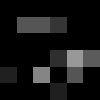

In [340]:
idx = random.randint(0,X_np.shape[0])
p = 255 * X_np[idx,:]
p = p.astype('int32')
p = p.reshape(6,6)
img = Image.fromarray(p)
img = img.convert('L')
img = img.resize((100,100),Image.NEAREST)

print('Clase')
print(dict_bin[y_bin[idx]])
print('')

print(p)
print('')

img

Datos para modelos de 2 clases

In [341]:
x_train, x_test, y_train, y_test = train_test_split(X_img, y_bin, test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\nDistribución de clases para entrenamiento")
print (pd.Series(y_train).value_counts())
print ("\nDistribución de clases para prueba")
print (pd.Series(y_test).value_counts())

(890836, 6, 6, 1) (890836,) (296946, 6, 6, 1) (296946,)

Distribución de clases para entrenamiento
1    598221
0    292615
Name: Class, dtype: int64

Distribución de clases para prueba
1    199559
0     97387
Name: Class, dtype: int64


Datos para modelos de 5 clases

In [342]:
xm_train, xm_test, ym_train, ym_test = train_test_split(X_img, y_multi, test_size=.25)
print (xm_train.shape, ym_train.shape, xm_test.shape, ym_test.shape)
print ("\nDistribución de clases para entrenamiento")
print (pd.Series(ym_train).value_counts())
print ("\nDistribución de clases para prueba")
print (pd.Series(ym_test).value_counts())

(890836, 6, 6, 1) (890836,) (296946, 6, 6, 1) (296946,)

Distribución de clases para entrenamiento
1    598538
0    287348
2      3427
3      1474
4        49
Name: Class, dtype: int64

Distribución de clases para prueba
1    199242
0     96082
2      1123
3       488
4        11
Name: Class, dtype: int64


# Modelos

## Modelo A. DS No balanceado + 2 clases + 1 Conv sin dropout

In [343]:
def get_conv_model_A(num_classes, img_size=6, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [344]:
num_classes = len(np.unique(y_bin))
model = get_conv_model_A(num_classes)

using 2 classes


In [345]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [346]:
model = get_conv_model_A(num_classes)
model.summary()

using 2 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 15)          150       
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 output_1 (Dense)            (None, 2)                 1082      
                                                                 
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
_________________________________________________________________


In [347]:
train(model, batch_size=32, epochs=10, model_name="model_A")

Epoch 1/10
27839/27839 [==============================] - 84s 3ms/step - loss: 0.0490 - accuracy: 0.9824 - val_loss: 0.0271 - val_accuracy: 0.9880
Epoch 2/10
27839/27839 [==============================] - 67s 2ms/step - loss: 0.0239 - accuracy: 0.9908 - val_loss: 0.0218 - val_accuracy: 0.9915
Epoch 3/10
27839/27839 [==============================] - 66s 2ms/step - loss: 0.0207 - accuracy: 0.9919 - val_loss: 0.0203 - val_accuracy: 0.9920
Epoch 4/10
27839/27839 [==============================] - 77s 3ms/step - loss: 0.0188 - accuracy: 0.9929 - val_loss: 0.0185 - val_accuracy: 0.9932
Epoch 5/10
27839/27839 [==============================] - 66s 2ms/step - loss: 0.0173 - accuracy: 0.9937 - val_loss: 0.0173 - val_accuracy: 0.9939
Epoch 6/10
27839/27839 [==============================] - 67s 2ms/step - loss: 0.0161 - accuracy: 0.9943 - val_loss: 0.0155 - val_accuracy: 0.9944
Epoch 7/10
27839/27839 [==============================] - 67s 2ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0

{'accuracy': 0.9966256618499756, 'loss': 0.014199890196323395}

In [348]:
y_preds = model.predict(x_test).argmax(axis=1)

Accuracy:  0.9966256491079186  F1-Score:  0.996175591835823


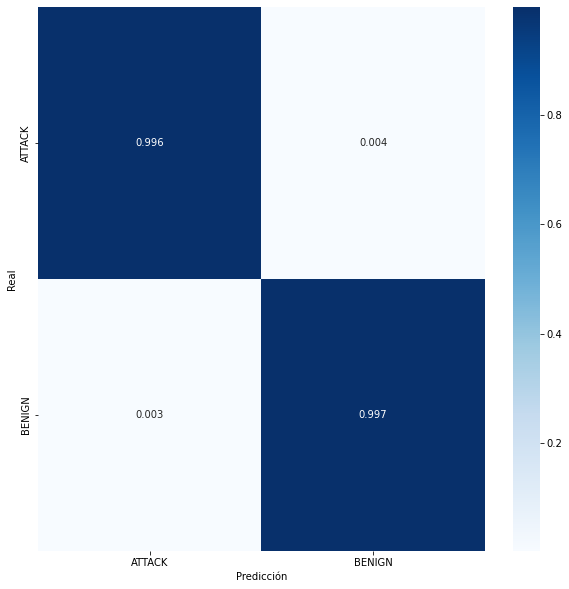

In [351]:
print("Accuracy: ",accuracy_score(y_test,y_preds), " F1-Score: ", f1_score(y_test,y_preds, average = "macro"))

matrix_conf(y_test, y_preds, dict_bin.values())

## Modelo B. DS no balanceado + 5 clases + 1 Conv sin droput

In [352]:
def get_conv_model_B(num_classes, img_size=6, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [353]:
num_classes = len(np.unique(y_multi))
model = get_conv_model_B(num_classes)

using 5 classes


In [354]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(xm_train, ym_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(xm_test, ym_test))
    metrics = model.evaluate(xm_test, ym_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [355]:
model = get_conv_model_B(num_classes)
model.summary()

using 5 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 15)          150       
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 output_1 (Dense)            (None, 5)                 2705      
                                                                 
Total params: 2,855
Trainable params: 2,855
Non-trainable params: 0
_________________________________________________________________


In [356]:
train(model, batch_size=32, epochs=10, model_name="model_B")

Epoch 1/10
27839/27839 [==============================] - 81s 3ms/step - loss: 0.0562 - accuracy: 0.9795 - val_loss: 0.0296 - val_accuracy: 0.9893
Epoch 2/10
27839/27839 [==============================] - 77s 3ms/step - loss: 0.0255 - accuracy: 0.9892 - val_loss: 0.0247 - val_accuracy: 0.9912
Epoch 3/10
27839/27839 [==============================] - 77s 3ms/step - loss: 0.0225 - accuracy: 0.9902 - val_loss: 0.0213 - val_accuracy: 0.9909
Epoch 4/10
27839/27839 [==============================] - 76s 3ms/step - loss: 0.0204 - accuracy: 0.9910 - val_loss: 0.0202 - val_accuracy: 0.9903
Epoch 5/10
27839/27839 [==============================] - 68s 2ms/step - loss: 0.0189 - accuracy: 0.9919 - val_loss: 0.0190 - val_accuracy: 0.9921
Epoch 6/10
27839/27839 [==============================] - 70s 3ms/step - loss: 0.0177 - accuracy: 0.9927 - val_loss: 0.0178 - val_accuracy: 0.9928
Epoch 7/10
27839/27839 [==============================] - 67s 2ms/step - loss: 0.0168 - accuracy: 0.9933 - val_loss: 0

{'accuracy': 0.9940292239189148, 'loss': 0.014991449192166328}

In [357]:
ym_preds = model.predict(xm_test).argmax(axis=1)

Accuracy:  0.9940292174334727  F1-Score:  0.5461939332798742


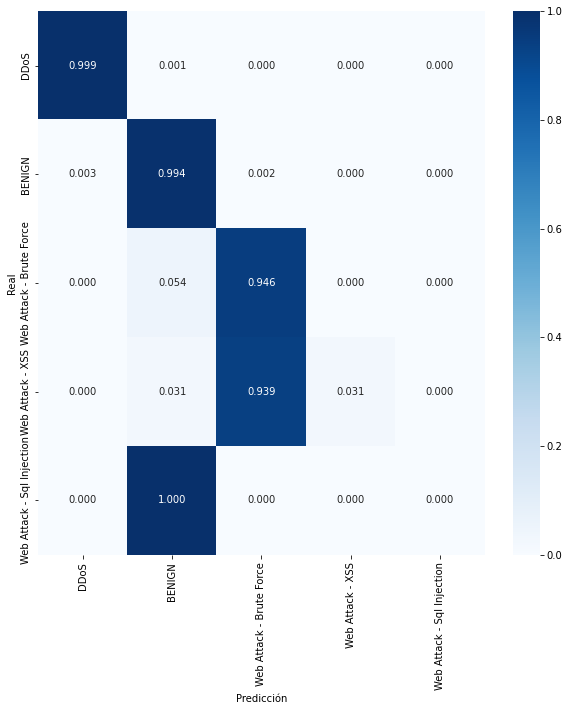

In [358]:
print("Accuracy: ",accuracy_score(ym_test,ym_preds), " F1-Score: ", f1_score(ym_test,ym_preds, average = "macro"))
matrix_conf(ym_test, ym_preds, dict_multi.values())

## Modelo C. DS no balanceado + 5 clases + 1 Conv 1 Dense con dropout




In [359]:
def get_conv_model_C(num_classes, img_size=6, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [360]:
num_classes = len(np.unique(y_multi))
model = get_conv_model_C(num_classes)

using 5 classes


In [361]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(xm_train, ym_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(xm_test, ym_test))
    metrics = model.evaluate(xm_test, ym_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [362]:
model = get_conv_model_C(num_classes)
model.summary()

using 5 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 15)          150       
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 16)                8656      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 output_1 (Dense)            (None, 5)                 85        
                                                                 
Total params: 8,891
Trainable params: 8,891
N

In [363]:
train(model, batch_size=32, epochs=10, model_name="model_C")

Epoch 1/10
27839/27839 [==============================] - 73s 3ms/step - loss: 0.0530 - accuracy: 0.9811 - val_loss: 0.0256 - val_accuracy: 0.9880
Epoch 2/10
27839/27839 [==============================] - 80s 3ms/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 0.0211 - val_accuracy: 0.9920
Epoch 3/10
27839/27839 [==============================] - 80s 3ms/step - loss: 0.0231 - accuracy: 0.9915 - val_loss: 0.0176 - val_accuracy: 0.9944
Epoch 4/10
27839/27839 [==============================] - 80s 3ms/step - loss: 0.0194 - accuracy: 0.9931 - val_loss: 0.0171 - val_accuracy: 0.9933
Epoch 5/10
27839/27839 [==============================] - 80s 3ms/step - loss: 0.0173 - accuracy: 0.9938 - val_loss: 0.0164 - val_accuracy: 0.9932
Epoch 6/10
27839/27839 [==============================] - 71s 3ms/step - loss: 0.0159 - accuracy: 0.9943 - val_loss: 0.0125 - val_accuracy: 0.9955
Epoch 7/10
27839/27839 [==============================] - 80s 3ms/step - loss: 0.0147 - accuracy: 0.9946 - val_loss: 0

{'accuracy': 0.9960767030715942, 'loss': 0.009691043756902218}

In [364]:
ym_preds = model.predict(xm_test).argmax(axis=1)

Accuracy:  0.9960767277552147  F1-Score:  0.5333374535916504


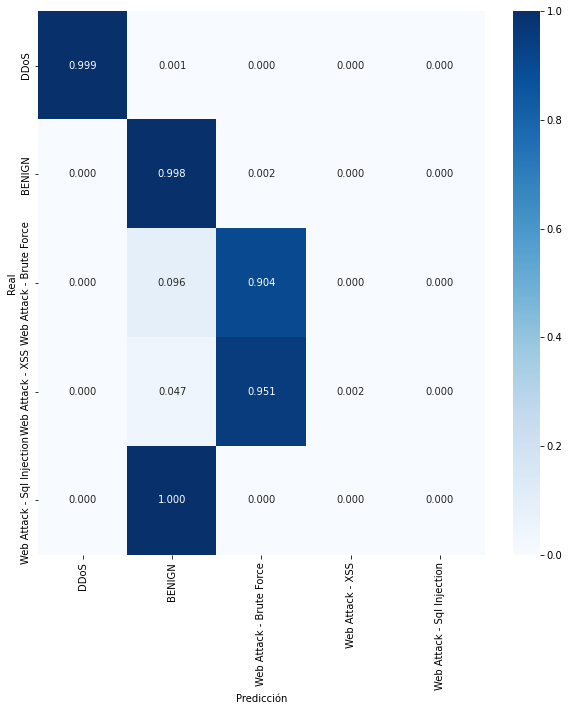

In [365]:
print("Accuracy: ",accuracy_score(ym_test,ym_preds), " F1-Score: ", f1_score(ym_test,ym_preds, average = "macro"))
matrix_conf(ym_test, ym_preds, dict_multi.values())

## Modelo D. DS no balanceado + 5 clases + 2 Conv 1 Dense con dropout/pooling

In [366]:
def get_conv_model_D(num_classes, img_size=6, compile=True):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(2,2), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(2,2), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [367]:
num_classes = len(np.unique(y_multi))
model = get_conv_model_D(num_classes)

using 5 classes


In [369]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(xm_train, ym_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(xm_test, ym_test))
    metrics = model.evaluate(xm_test, ym_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [370]:
model = get_conv_model_D(num_classes)
model.summary()

using 5 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 15)          75        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 15)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 60)          3660      
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 16)                976       
                                             

In [371]:
train(model, batch_size=32, epochs=10, model_name="model_D")

Epoch 1/10
27839/27839 [==============================] - 94s 3ms/step - loss: 0.0897 - accuracy: 0.9717 - val_loss: 0.0449 - val_accuracy: 0.9861
Epoch 2/10
27839/27839 [==============================] - 89s 3ms/step - loss: 0.0408 - accuracy: 0.9872 - val_loss: 0.0403 - val_accuracy: 0.9857
Epoch 3/10
27839/27839 [==============================] - 83s 3ms/step - loss: 0.0330 - accuracy: 0.9892 - val_loss: 0.0375 - val_accuracy: 0.9891
Epoch 4/10
27839/27839 [==============================] - 72s 3ms/step - loss: 0.0293 - accuracy: 0.9901 - val_loss: 0.0240 - val_accuracy: 0.9925
Epoch 5/10
27839/27839 [==============================] - 71s 3ms/step - loss: 0.0257 - accuracy: 0.9907 - val_loss: 0.0202 - val_accuracy: 0.9918
Epoch 6/10
27839/27839 [==============================] - 81s 3ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.0191 - val_accuracy: 0.9945
Epoch 7/10
27839/27839 [==============================] - 81s 3ms/step - loss: 0.0217 - accuracy: 0.9925 - val_loss: 0

{'accuracy': 0.9945511817932129, 'loss': 0.01725051738321781}

In [372]:
ym_preds = model.predict(xm_test).argmax(axis=1)

Accuracy:  0.9945511978608905  F1-Score:  0.5295262001660482


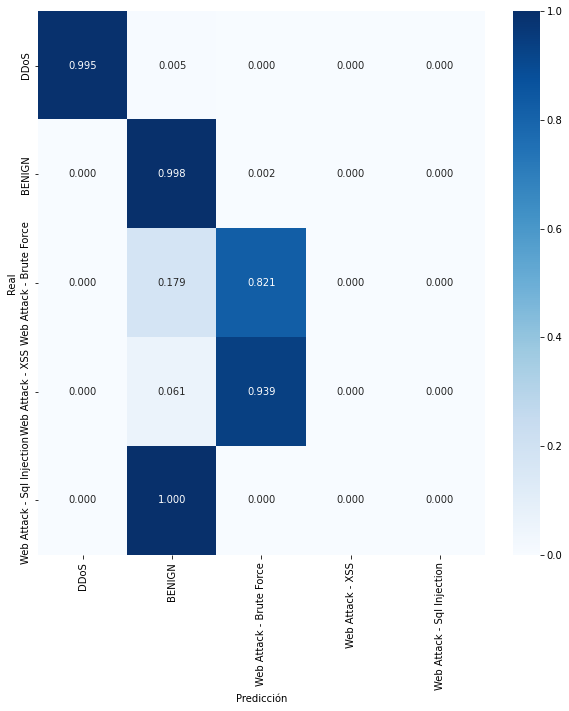

In [373]:
print("Accuracy: ",accuracy_score(ym_test,ym_preds), " F1-Score: ", f1_score(ym_test,ym_preds, average = "macro"))
matrix_conf(ym_test, ym_preds, dict_multi.values())